In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [26]:
dataset = pd.read_csv('../secondMMRintData/0OrbitTest.csv')

In [27]:
dataset[outer+twoBRwidth+twoBRinW]

,EMcrossouter,EMfracstdouter,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MMRstrengthWnear,MMRstrengthWfar,MMRstrengthWouter,twoMMRstrengthWnear,twoMMRstrengthWfar,twoMMRstrengthWouter,MMRinWidnear,MMRinWidfar,MMRinWidouter,twoMMRinWidnear,twoMMRinWidfar,twoMMRinWidouter
0,0.589043,0.0,0.0,0.440409,0.000000,0.013615,0.008864,0.004330,7.075038e-03,0.001976,0.000000,0.0,1.0,0.0,1.0,1.0,0.0
1,0.671403,0.0,0.0,0.000144,0.000000,0.002670,0.008266,0.000482,4.107756e-05,0.004294,0.000000,1.0,0.0,1.0,1.0,1.0,0.0
2,0.936762,0.0,0.0,0.000833,0.000221,0.033117,0.000140,0.001826,2.216802e-02,0.000436,0.000244,0.0,1.0,1.0,0.0,1.0,1.0
3,0.503164,0.0,0.0,0.000257,0.000190,0.000209,0.001205,0.000376,1.511511e-07,0.004377,0.000075,1.0,1.0,1.0,1.0,1.0,1.0
4,0.059346,0.0,0.0,0.108506,0.008287,0.003860,0.000560,0.001814,5.812017e-03,0.001159,0.001801,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,0.801058,0.0,0.0,0.009373,0.002514,0.007770,0.004526,0.008727,7.892905e-03,0.000000,0.004618,0.0,1.0,1.0,1.0,0.0,1.0
138539,0.592730,0.0,0.0,0.159102,0.000000,0.002360,0.006502,0.005090,1.041106e-03,0.000784,0.000000,0.0,1.0,0.0,1.0,1.0,0.0
138540,0.546790,0.0,0.0,0.072739,0.000076,0.017718,0.002482,0.018170,1.722615e-02,0.004660,0.000292,0.0,0.0,1.0,1.0,1.0,1.0
138541,0.687277,0.0,0.0,0.002346,0.002293,0.033013,0.005279,0.005187,5.796469e-02,0.002222,0.006899,0.0,1.0,1.0,0.0,1.0,1.0


In [28]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [29]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 6.01 s, sys: 52 ms, total: 6.07 s
Wall time: 6.07 s


In [39]:
#removed twoMMRs 
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
outer = ['EMcrossouter', 'EMfracstdouter', 'EPstdouter', 'MMRstrengthouter','twoMMRstrengthouter']
megno = ['MEGNO', 'MEGNOstd']
threeBR = ['threeBRfillfac', 'threeBRfillstd']
#what is being used to train

twoBRwidth = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
twoBRinW = ['MMRinWidnear','MMRinWidfar','MMRinWidouter','twoMMRinWidnear','twoMMRinWidfar','twoMMRinWidouter']

features = near + far + outer + megno + threeBR + twoBRwidth +twoBRinW
OGfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']
Oldfeatures = near + far + outer + megno + threeBR 
threeMegno = threeBR+OGfeatures
MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','twoMMRstrengthnear','twoMMRstrengthfar','twoMMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter']+twoBRwidth
MMRDataTest = ['threeBRfillfac', 'EMcrossnear','EMcrossfar','EMcrossouter']+twoBRwidth
TestFirst = ['threeBRfillfac', 'threeBRfillstd','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter']

In [7]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [8]:
filtData

,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,...,twoMMRstrengthWouter,MEGNO,MEGNOstd,threeBRfillfac,threeBRfillstd,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,0,0.221502,0.0,0.0,0.098431,9.878834e-03,0.0,0.013615,1.0,7.075038e-03,...,0.000000,0.0,0.0,0.447352,0.0,True,False,1.235665e+07,8.315223e+07,0
1,1,0.190647,0.0,0.0,0.009185,1.703367e-03,1.0,0.002670,1.0,4.107756e-05,...,0.000000,0.0,0.0,0.387809,0.0,True,False,1.348749e+05,2.133072e+05,0
2,2,0.125660,0.0,0.0,0.426660,1.310313e-01,0.0,0.033117,0.0,2.216802e-02,...,0.000244,0.0,0.0,0.892770,0.0,True,False,1.276428e+04,9.321863e+03,0
3,3,0.216684,0.0,0.0,0.002876,1.857040e-07,1.0,0.000209,1.0,1.511511e-07,...,0.000075,0.0,0.0,0.083149,0.0,True,True,1.000000e+09,1.000000e+09,0
4,4,0.024455,0.0,0.0,0.423830,1.145611e-01,0.0,0.003860,0.0,5.812017e-03,...,0.001801,0.0,0.0,35.774018,0.0,True,False,8.791890e+01,8.791890e+01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.0,0.0,0.447117,2.475049e-02,0.0,0.007770,1.0,7.892905e-03,...,0.004618,0.0,0.0,0.776506,0.0,True,False,6.990387e+05,8.267916e+05,0
138539,138539,0.251338,0.0,0.0,0.749336,1.701463e-03,0.0,0.002360,1.0,1.041106e-03,...,0.000000,0.0,0.0,0.206226,0.0,True,False,3.075749e+08,6.576003e+08,0
138540,138540,0.131799,0.0,0.0,0.324267,2.940005e-02,0.0,0.017718,1.0,1.722615e-02,...,0.000292,0.0,0.0,0.890745,0.0,True,False,1.193822e+07,3.363291e+07,0
138541,138541,0.209454,0.0,0.0,1.205802,5.207774e-02,0.0,0.033013,0.0,5.796469e-02,...,0.006899,0.0,0.0,0.375527,0.0,True,False,2.064407e+08,4.316851e+07,0


In [9]:
scrambled = filtData.sample(frac=1)

In [10]:
scrambled = scrambled.reset_index()

In [11]:
scrambled

,level_0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,...,twoMMRstrengthWouter,MEGNO,MEGNOstd,threeBRfillfac,threeBRfillstd,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,92893,92893,0.065621,0.0,0.0,2.505135,0.007435,0.0,0.001939,1.0,...,0.000365,0.0,0.0,0.108754,0.0,True,True,1.000000e+09,1.000000e+09,0
1,15343,15343,0.152715,0.0,0.0,0.005632,0.001485,1.0,0.000767,1.0,...,0.000056,0.0,0.0,0.062628,0.0,True,True,1.000004e+09,1.000004e+09,0
2,19311,19311,0.056514,0.0,0.0,0.049960,0.028703,0.0,0.004069,1.0,...,0.000060,0.0,0.0,0.654039,0.0,True,False,5.424783e+01,5.424783e+01,0
3,108277,108277,0.041203,0.0,0.0,0.898508,0.014749,0.0,0.002342,1.0,...,0.000453,0.0,0.0,1.864693,0.0,True,False,2.521042e+06,9.792905e+05,0
4,112173,112173,0.129297,0.0,0.0,2.097700,0.004466,0.0,0.002410,1.0,...,0.000039,0.0,0.0,0.402305,0.0,True,False,6.739006e+08,4.932220e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,40330,40330,0.050791,0.0,0.0,0.911595,0.035110,0.0,0.006770,0.0,...,0.000006,0.0,0.0,2.712980,0.0,True,False,1.055629e+06,1.354173e+06,0
138539,60973,60973,0.071572,0.0,0.0,0.128221,0.023205,0.0,0.005638,1.0,...,0.001043,0.0,0.0,3.358804,0.0,True,False,2.474192e+06,6.363431e+07,0
138540,66511,66511,0.142944,0.0,0.0,0.164983,0.011208,0.0,0.001220,1.0,...,0.000008,0.0,0.0,0.160359,0.0,True,True,1.000000e+09,1.000000e+09,0
138541,24315,24315,0.526121,0.0,0.0,0.002301,0.001644,1.0,0.005097,1.0,...,0.000002,0.0,0.0,0.045861,0.0,True,True,1.000002e+09,1.000002e+09,0


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [66]:
dataset['prelimStable'].value_counts()[False]

KeyError: False

In [12]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]

# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [13]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [14]:
realTest = test.loc[test['prelimStable']==True]

In [15]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [46]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
train

,level_0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,...,twoMMRstrengthWouter,MEGNO,MEGNOstd,threeBRfillfac,threeBRfillstd,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,92893,92893,0.065621,0.0,0.0,2.505135,0.007435,0.0,0.001939,1.0,...,0.000365,0.0,0.0,0.108754,0.0,True,True,1.000000e+09,1.000000e+09,0
1,15343,15343,0.152715,0.0,0.0,0.005632,0.001485,1.0,0.000767,1.0,...,0.000056,0.0,0.0,0.062628,0.0,True,True,1.000004e+09,1.000004e+09,0
2,19311,19311,0.056514,0.0,0.0,0.049960,0.028703,0.0,0.004069,1.0,...,0.000060,0.0,0.0,0.654039,0.0,True,False,5.424783e+01,5.424783e+01,0
3,108277,108277,0.041203,0.0,0.0,0.898508,0.014749,0.0,0.002342,1.0,...,0.000453,0.0,0.0,1.864693,0.0,True,False,2.521042e+06,9.792905e+05,0
4,112173,112173,0.129297,0.0,0.0,2.097700,0.004466,0.0,0.002410,1.0,...,0.000039,0.0,0.0,0.402305,0.0,True,False,6.739006e+08,4.932220e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110829,32505,32505,0.200262,0.0,0.0,0.081995,0.015973,1.0,0.012713,0.0,...,0.000059,0.0,0.0,0.236053,0.0,True,True,1.000000e+09,1.000000e+09,0
110830,120001,120001,0.161660,0.0,0.0,0.899960,0.018796,0.0,0.019641,1.0,...,0.002938,0.0,0.0,3.436486,0.0,True,False,1.401394e+06,3.362693e+05,0
110831,37312,37312,0.115752,0.0,0.0,0.969204,0.131940,0.0,0.004989,0.0,...,0.001658,0.0,0.0,1.977340,0.0,True,False,1.576816e+05,5.836318e+02,0
110832,9796,9796,0.023706,0.0,0.0,0.319190,0.014381,0.0,0.001261,0.0,...,0.002848,0.0,0.0,60.168474,0.0,True,False,2.636251e+03,8.862904e+02,0


In [40]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [41]:
testModel.fit(train[MMRDataTest], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [47]:
resPred = testModel.predict_proba(tT[MMRDataTest])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[MMRDataTest]), tT["Stable"]))

0.9360941986450918
0.8434509160514082


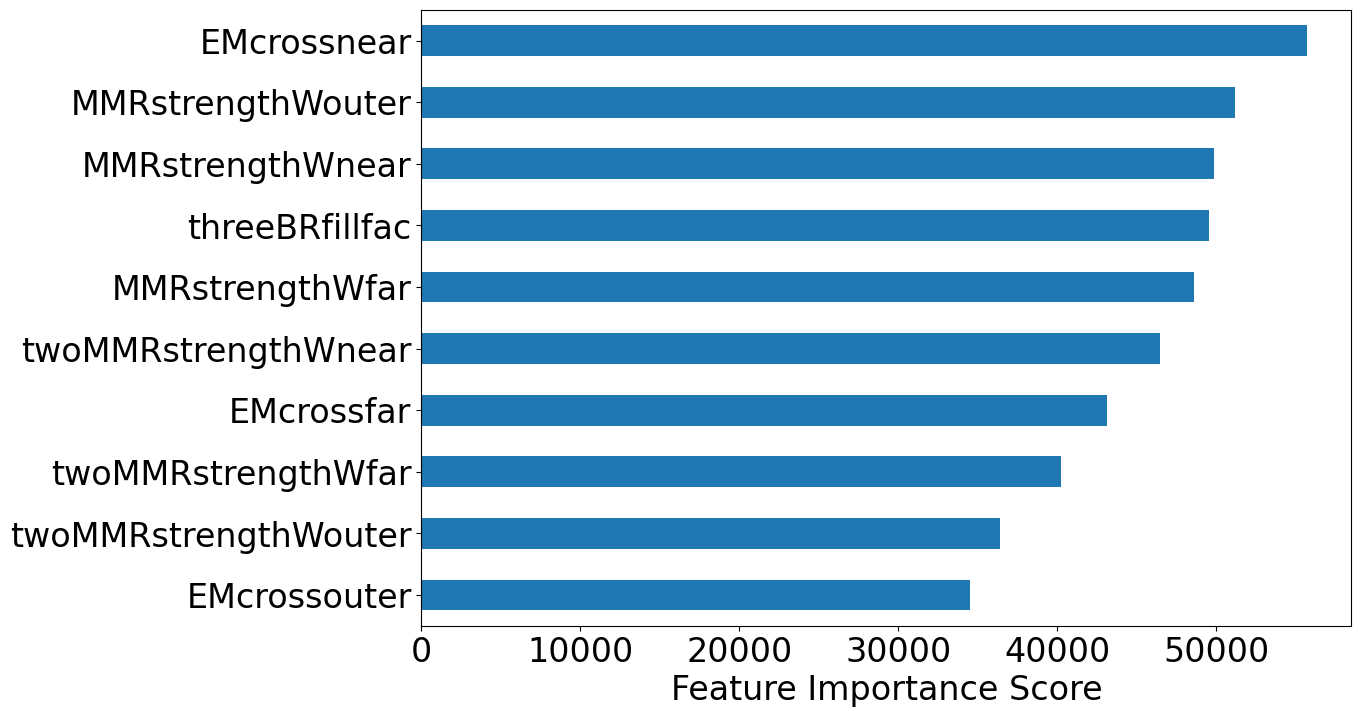

In [48]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [90]:
newModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [91]:
newModel.fit(train[features], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [92]:
resPred = newModel.predict_proba(realTest[features])[:,1]
newAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
newacc = accuracy_score(newModel.predict(realTest[features]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(newModel.predict(realTest[features]), realTest["Stable"]))

0.9724236065316946
0.9175195178188584


In [98]:
OldModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [99]:
OldModel.fit(train[Oldfeatures], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [100]:
resPred = OldModel.predict_proba(realTest[Oldfeatures])[:,1]
oldAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
oldacc = accuracy_score(OldModel.predict(realTest[Oldfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(OldModel.predict(realTest[Oldfeatures]), realTest["Stable"]))

0.9682111213159352
0.9100360017798633


In [101]:
oneModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         scale_pos_weight=resultBalance)
oneModel.fit(train[OGfeatures], train["Stable"])
resPred = oneModel.predict_proba(realTest[OGfeatures])[:,1]
oneMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
oneMMRacc = accuracy_score(oneModel.predict(realTest[OGfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(oneModel.predict(realTest[OGfeatures]), realTest["Stable"]))

0.9531695575960055
0.8871809392823915


In [102]:
print('OG compaired to improved model')
print(f'decrease in AOC: {((1-oneMMRAUC)-(1-newAUC))/(1-oneMMRAUC)}')
print(f'decrease in error: {((1-oneMMRacc)-(1-newacc))/(1-oneMMRacc)}')

OG compaired to improved model
decrease in AOC: 0.3328231447326524
decrease in error: 0.211903908210828


In [103]:
print('new compaired to old model')
print(f'decrease in AOC: {((1-oldAUC)-(1-newAUC))/(1-oldAUC)}')
print(f'decrease in error: {((1-oldacc)-(1-newacc))/(1-oldacc)}')

new compaired to old model
decrease in AOC: 0.017134652518024613
decrease in error: 0.011690647482013613


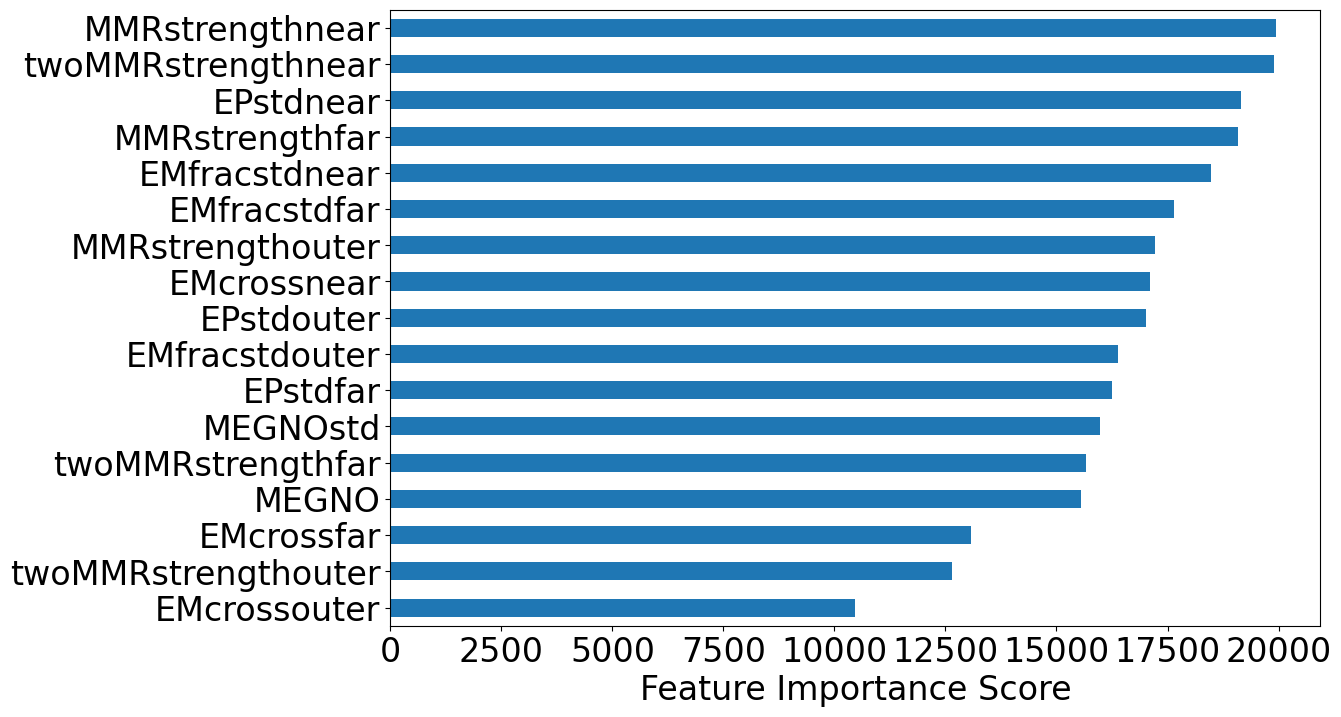

In [104]:
feat_imp = pd.Series(OldModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

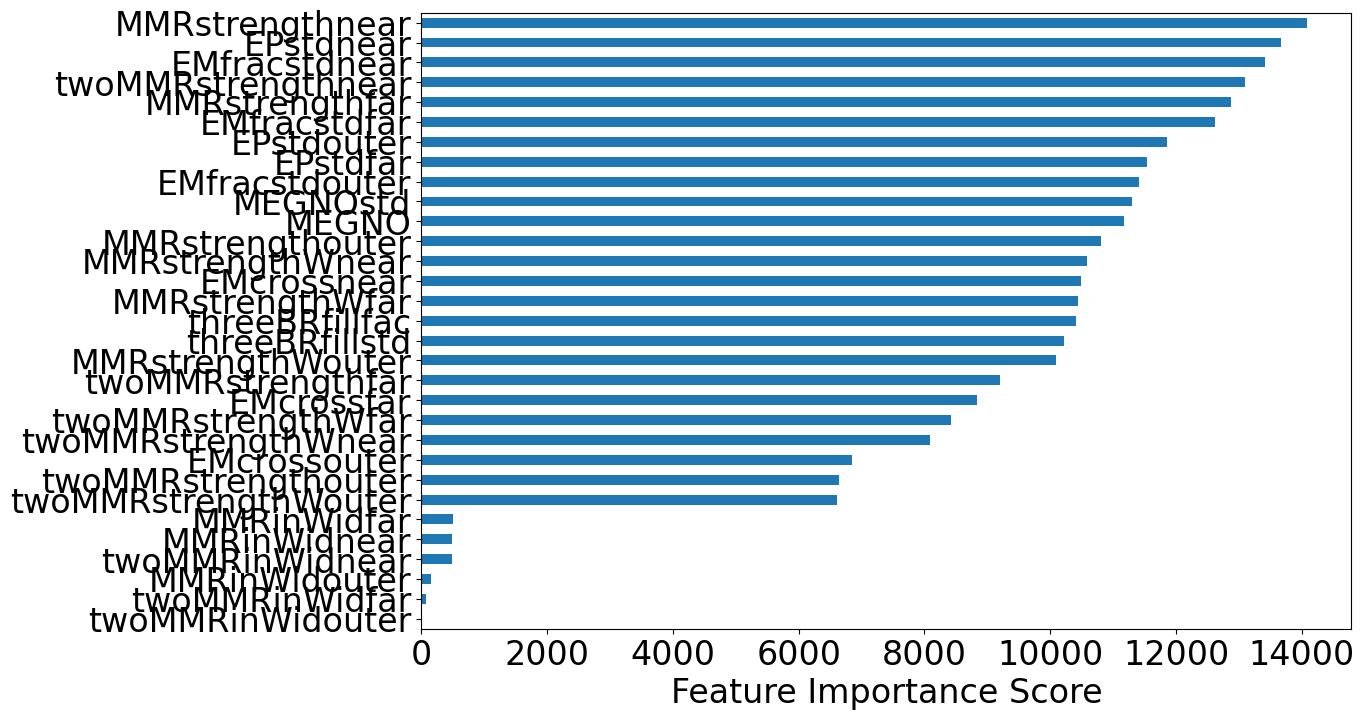

In [93]:
feat_imp = pd.Series(newModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0.0, 50.0)

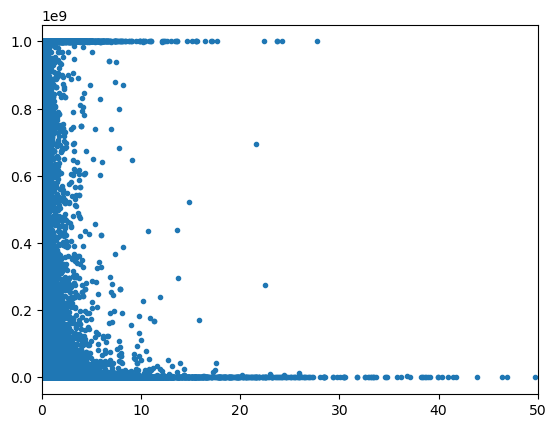

In [115]:
plt.plot(train['threeBRfillfac'],train['instability_time'], marker='.', ls = "")
ax = plt.gca()
ax.set_xlim([0, 50])